In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from transformers import AutoModelForCausalLM, AutoTokenizer

from core.utils.device import DEVICE
from core.utils.theme import set_theme

set_theme()

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B")
model.to(DEVICE)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")

# EN-RU


Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Data len:  50


100%|██████████| 50/50 [00:07<00:00,  6.71it/s]


Data len:  100


100%|██████████| 100/100 [00:12<00:00,  7.75it/s]


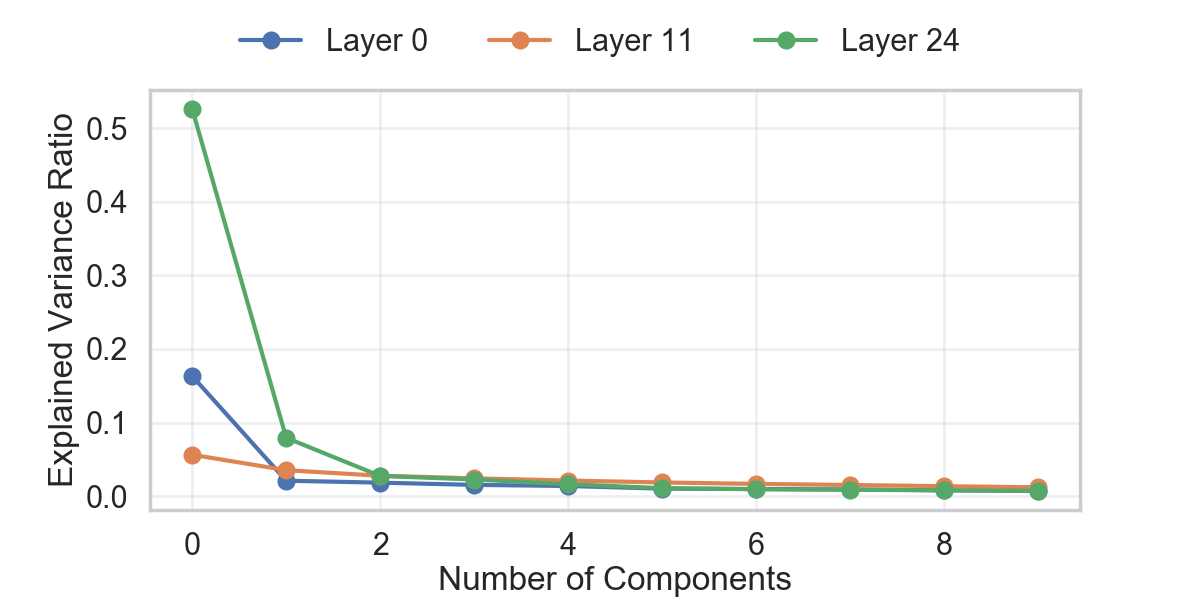

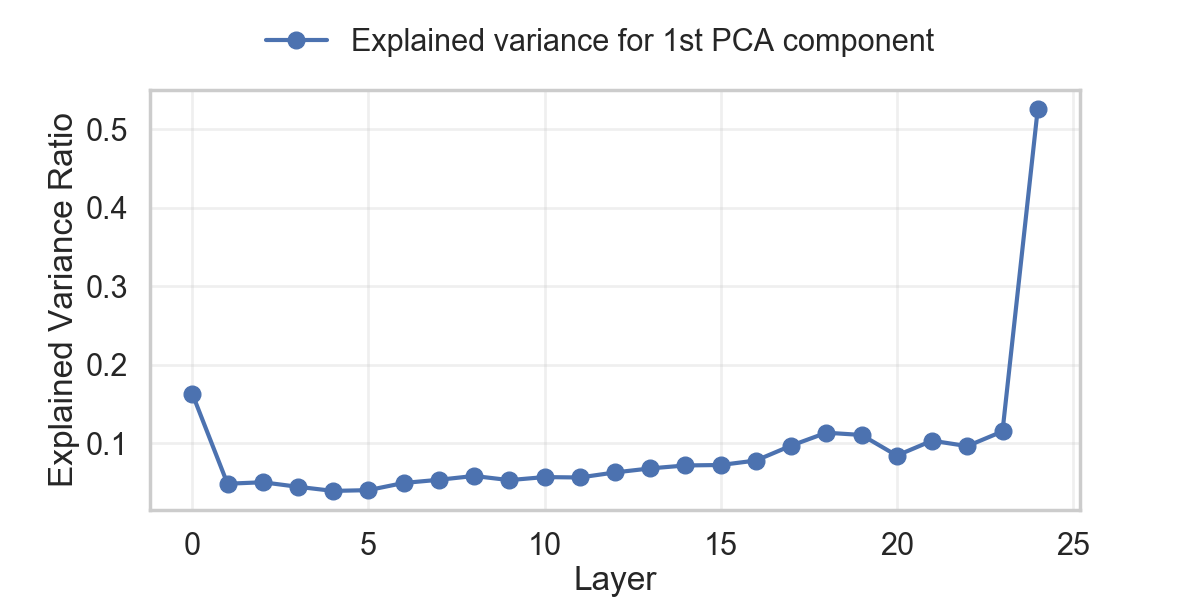

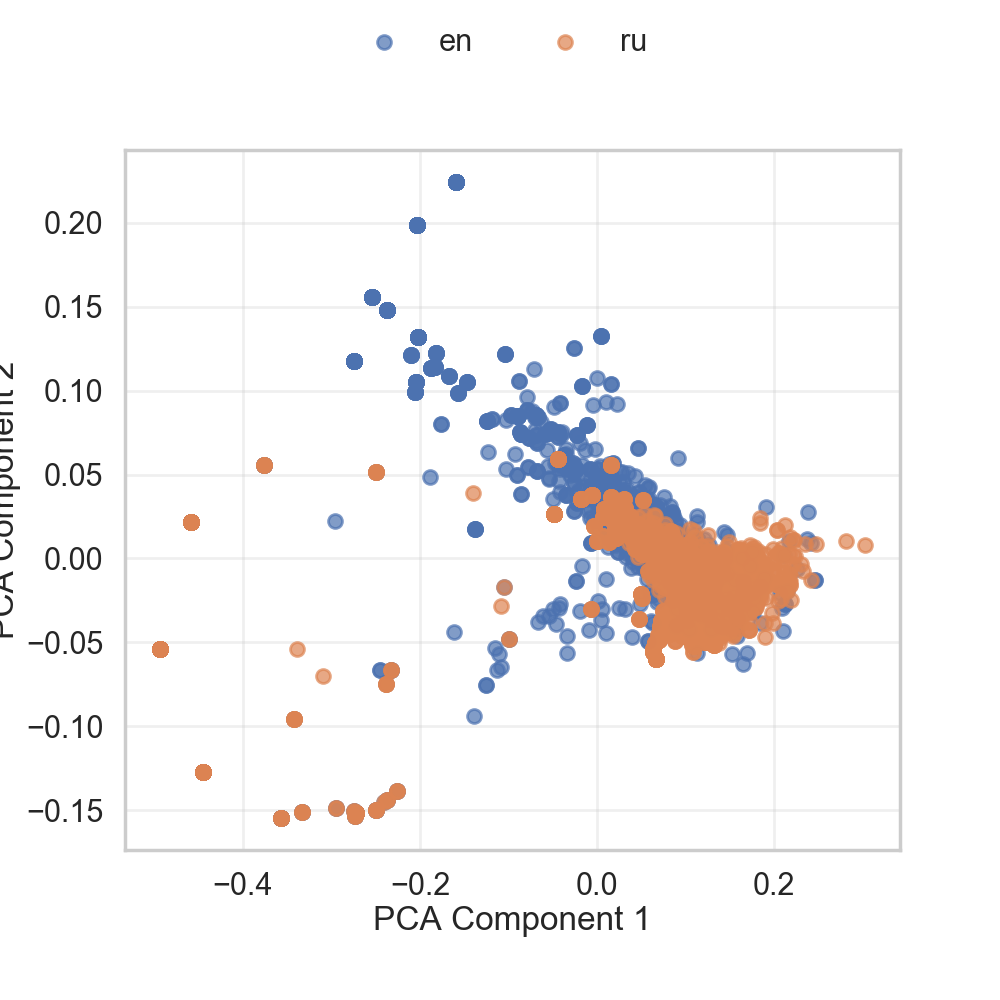

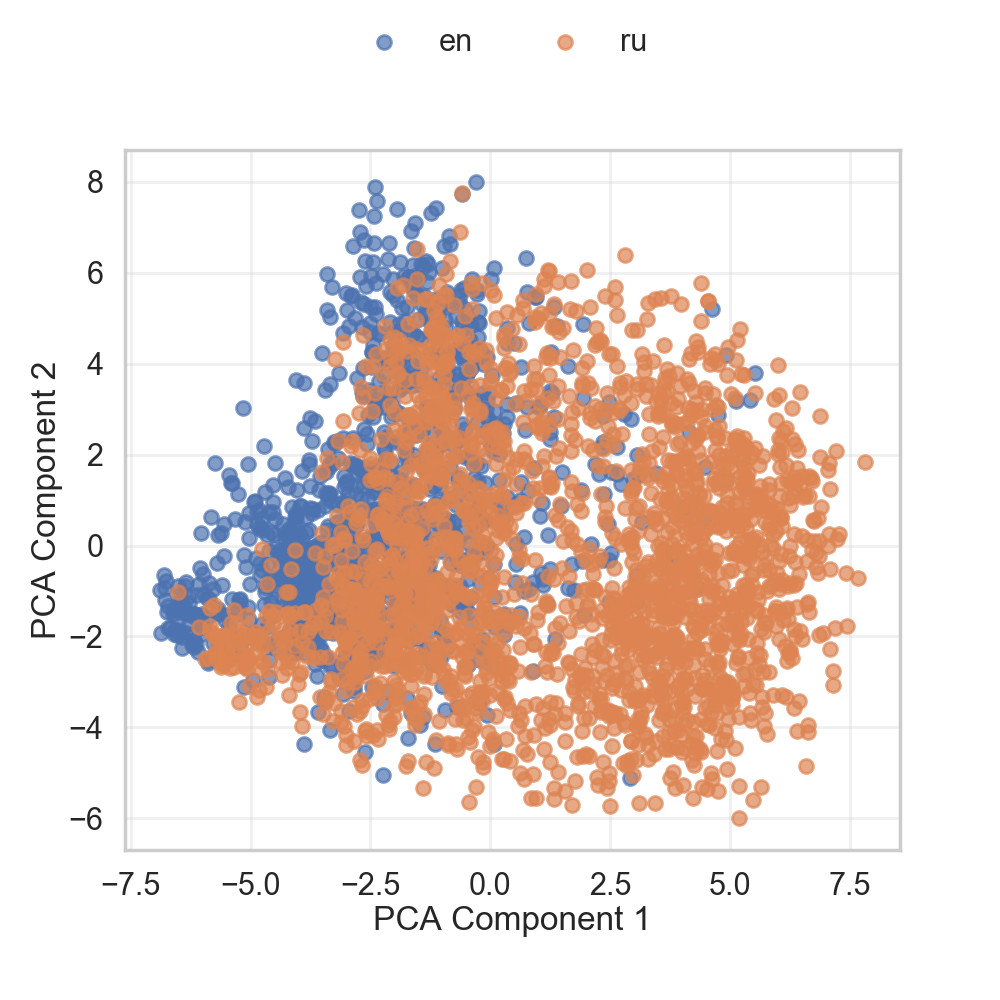

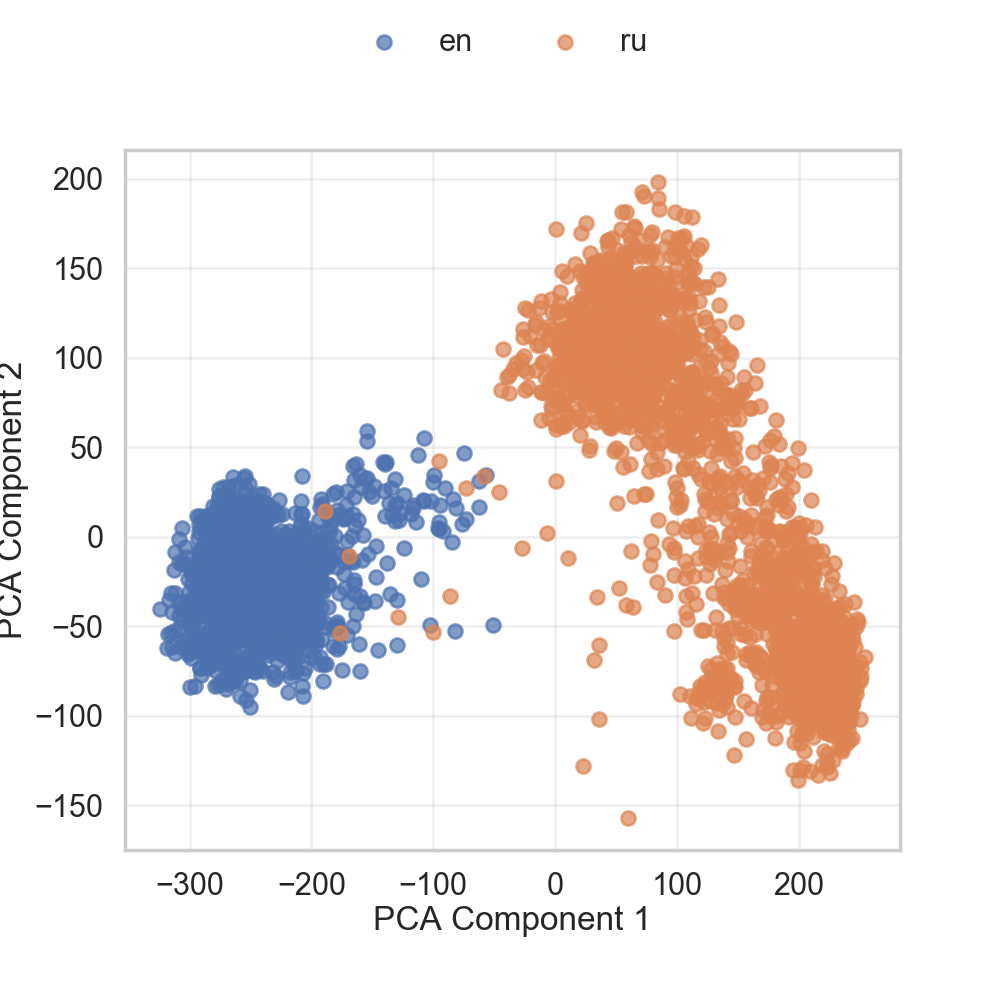

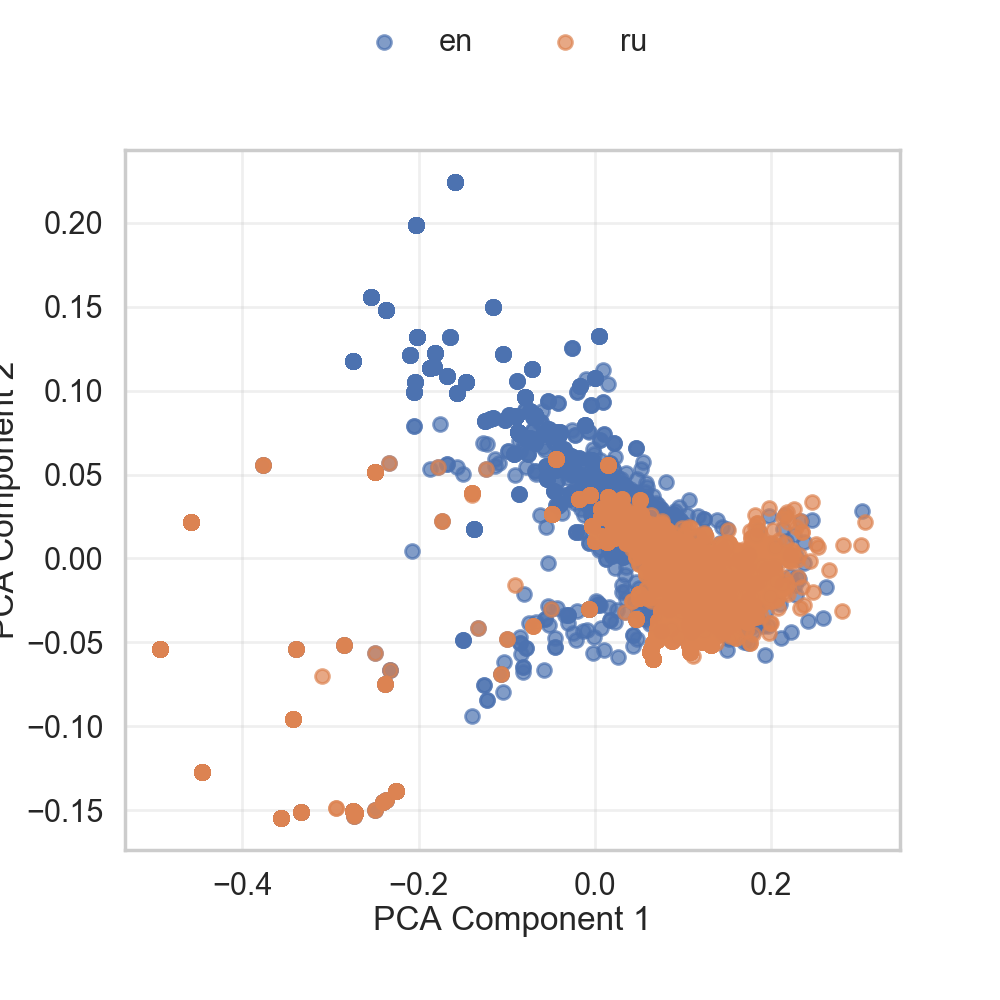

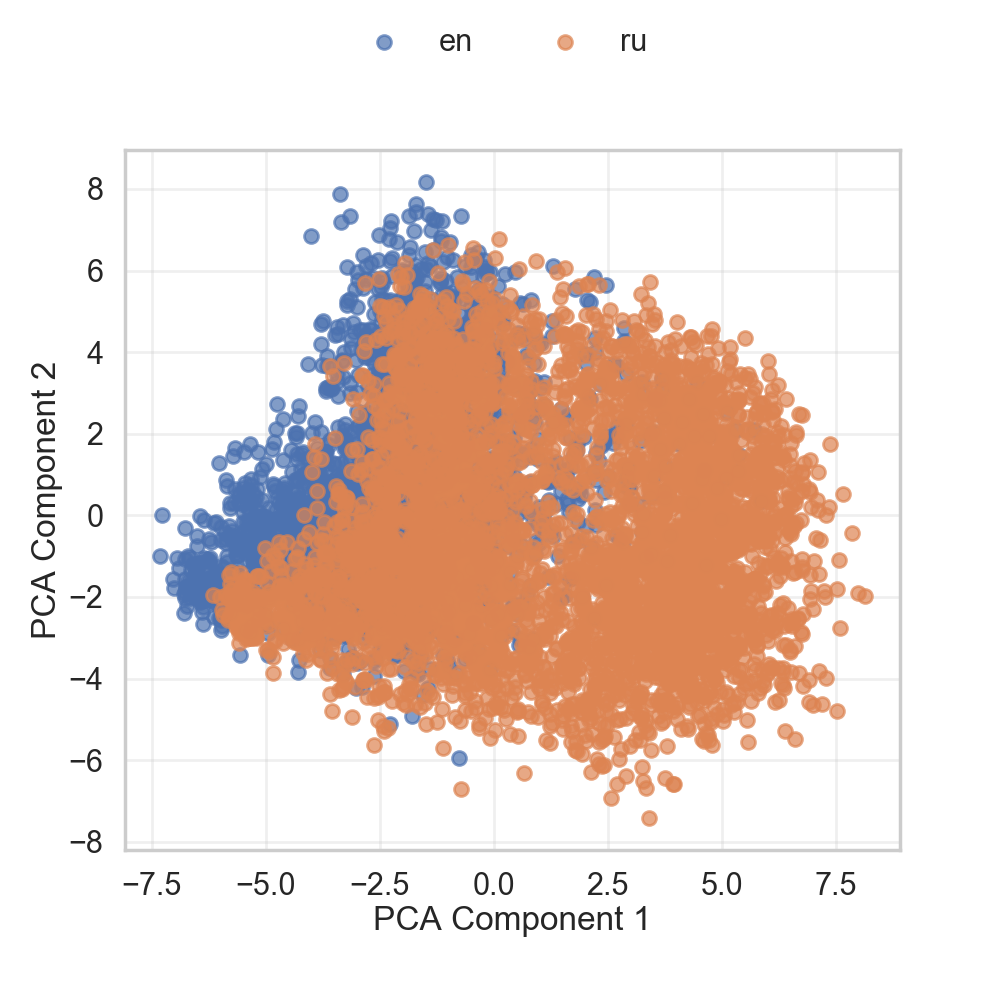

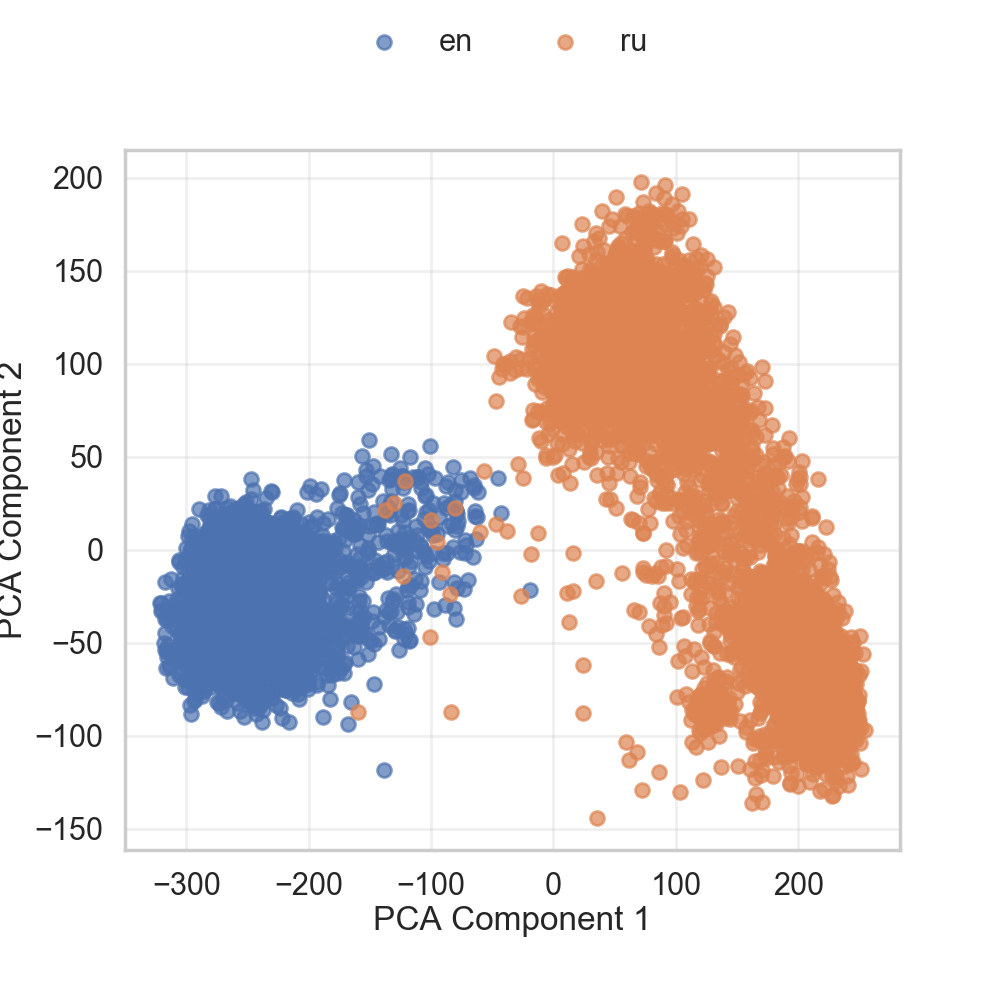

In [19]:
from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.preprocess_data.flores_plus import load_flores_plus
from core.steering.pca import PCASteering
from core.visualize.visualize_explained_variance import visualize_explained_variance
from core.visualize.visualize_projections import visualize_projections

train_df, test_df = load_flores_plus(["eng_Latn", "rus_Cyrl"], {"eng_Latn": "en", "rus_Cyrl": "ru"}, train_size=50)

test_df = test_df[:100]

hidden_space_by_language_train, token_map_for_language_train = collect_hidden_space_by_language(
    model, tokenizer, train_df, skip_first=True
)
hidden_space_by_language_test, token_map_for_language_test = collect_hidden_space_by_language(
    model, tokenizer, test_df, skip_first=True
)

pca_steering = PCASteering().fit(hidden_space_by_language_train)
visualize_explained_variance(pca_steering.explained_variance_ratios)

projections_train = pca_steering.project(hidden_space_by_language_train)
visualize_projections(hidden_space_by_language_train, token_map_for_language_train, projections_train, tokenizer)

projections_test = pca_steering.project(hidden_space_by_language_test)
visualize_projections(hidden_space_by_language_test, token_map_for_language_test, projections_test, tokenizer)

In [20]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [21]:
model.model.layers

ModuleList(
  (0-23): 24 x Qwen2DecoderLayer(
    (self_attn): Qwen2Attention(
      (q_proj): Linear(in_features=896, out_features=896, bias=True)
      (k_proj): Linear(in_features=896, out_features=128, bias=True)
      (v_proj): Linear(in_features=896, out_features=128, bias=True)
      (o_proj): Linear(in_features=896, out_features=896, bias=False)
    )
    (mlp): Qwen2MLP(
      (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
      (up_proj): Linear(in_features=896, out_features=4864, bias=False)
      (down_proj): Linear(in_features=4864, out_features=896, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
    (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
  )
)

In [40]:
import torch
import torch.nn as nn

flip = 0


# --- 1. Define the Custom Layer ---
# This layer will perform the reflection based on the first PCA component of the final layer.
class CustomReflectionLayer(nn.Module):
    def __init__(self, pca_components, pca_means):
        super().__init__()
        # Store the first PCA component and mean of the last layer
        # We need to register them as buffers if we want to move the whole model to a device
        self.register_buffer("first_pca_component", torch.tensor(pca_components[-2][:1]))
        self.register_buffer("pca_mean", torch.tensor(pca_means[-2]))
        self.register_buffer("first_projected_embeddings", None)
        self.first_run = True

    def forward(self, x):
        # The input 'x' is the hidden state from the previous layer
        # Shape: (batch_size, sequence_length, hidden_size)

        # Center the embeddings
        centered_embeddings = x - self.pca_mean

        # Project onto the first PCA component
        projected_embeddings = centered_embeddings @ self.first_pca_component.T @ self.first_pca_component

        # Reconstruct the projection in the original space

        # Reshape back to original
        # projected_embeddings = projected_embeddings.view(original_shape)

        # If reflection is disabled, just pass through
        if flip == 0:
            return x

        # --- Logic to decide whether to flip ---
        if self.first_run:
            # On the first run, we establish the reference direction.
            # We will flip against this direction.
            self.first_projected_embeddings = projected_embeddings.detach().clone()
            self.first_projected_embeddings = self.first_projected_embeddings.view(
                -1, projected_embeddings.shape[-1]
            ).mean(dim=0)
            self.first_run = False
            # Always flip on the first run if flip=True
            return x + flip * projected_embeddings

        # On subsequent runs, compare each token's projection to the reference direction individually.
        # min_len_seq = min(projected_embeddings.shape[1], self.first_projected_embeddings.shape[1])
        # print("min_len_seq", min_len_seq)

        dot_products = projected_embeddings @ self.first_projected_embeddings.T

        # Create a mask where dot product is positive.
        # Shape: (batch_size, min_len_seq, 1) to allow broadcasting
        flip_mask = (dot_products > 0).unsqueeze(-1)
        # print(flip_mask)

        # Create a tensor for the modifications.
        # Initialize with zeros, so tokens that shouldn't be flipped are not affected.
        modification = torch.zeros_like(projected_embeddings)

        # Apply the flip only where the mask is True.
        modification = flip_mask * (flip * projected_embeddings)

        # Add the sparse modifications to the original hidden state.
        return x + modification


# --- 2. Create a Wrapper to Inject the Custom Layer ---
# This wrapper is needed because the original layer's forward method takes multiple arguments,
# which a simple nn.Sequential cannot handle.
class InterposedLayer(nn.Module):
    def __init__(self, original_layer, custom_layer):
        super().__init__()
        self.original_layer = original_layer
        self.custom_layer = custom_layer
        # Copy necessary attributes from the original layer to the wrapper
        self.attention_type = original_layer.attention_type

    def forward(self, hidden_states, *args, **kwargs):
        # Pass all arguments to the original layer
        outputs = self.original_layer(hidden_states, *args, **kwargs)

        # The output of the original layer can be a tensor (use_cache=False) or a tuple (use_cache=True).
        # We need to handle both cases to avoid errors in the subsequent model layers.
        if isinstance(outputs, tuple):
            # When use_cache=True, output is a tuple (hidden_states, past_key_values)
            original_hidden_states = outputs[0]
            other_outputs = outputs[1:]

            # Apply our custom modification to the hidden states
            modified_hidden_states = self.custom_layer(original_hidden_states)

            # Reconstruct the tuple with the modified hidden states
            return (modified_hidden_states,) + other_outputs
        else:
            # When use_cache=False, output is just the hidden_states tensor
            original_hidden_states = outputs

            # Apply our custom modification to the hidden states
            modified_hidden_states = self.custom_layer(original_hidden_states)

            # Return only the modified tensor
            return modified_hidden_states


# --- 3. Inject the Wrapped Layer into the Model ---

# Get the last transformer block
last_layer_index = len(model.model.layers) - 2
original_last_layer = model.model.layers[last_layer_index]
print("layer", last_layer_index)

# Create our custom reflection layer
custom_reflection_layer = CustomReflectionLayer(pca_steering.pca_components, pca_steering.pca_means)
custom_reflection_layer.to(DEVICE)  # Move it to the same device as the model

# Create the wrapper that combines the original layer and our custom layer
interposed_layer = InterposedLayer(original_last_layer, custom_reflection_layer)

# Replace the original last layer with our new wrapped layer
model.model.layers[last_layer_index] = interposed_layer

print(f"Successfully injected CustomReflectionLayer after layer {last_layer_index}.")
print("Original last layer:", original_last_layer)
print("Modified last layer:", model.model.layers[last_layer_index])


# --- 4. (Optional but recommended) Add a function to restore the model ---
def restore_original_model():
    global model
    # Check if the layer is our wrapper before trying to restore
    if isinstance(model.model.layers[last_layer_index], InterposedLayer):
        print(f"Restoring original layer at index {last_layer_index}...")
        model.model.layers[last_layer_index] = original_last_layer
        print("Model restored.")


# You can call restore_original_model() later if you need to.

layer 22
Successfully injected CustomReflectionLayer after layer 22.
Original last layer: Qwen2DecoderLayer(
  (self_attn): Qwen2Attention(
    (q_proj): Linear(in_features=896, out_features=896, bias=True)
    (k_proj): Linear(in_features=896, out_features=128, bias=True)
    (v_proj): Linear(in_features=896, out_features=128, bias=True)
    (o_proj): Linear(in_features=896, out_features=896, bias=False)
  )
  (mlp): Qwen2MLP(
    (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
    (up_proj): Linear(in_features=896, out_features=4864, bias=False)
    (down_proj): Linear(in_features=4864, out_features=896, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
  (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
)
Modified last layer: InterposedLayer(
  (original_layer): Qwen2DecoderLayer(
    (self_attn): Qwen2Attention(
      (q_proj): Linear(in_features=896, out_features=896, bias=True)
      (k_proj): Linear(in_feature

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_91087/2475591148.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("first_pca_component", torch.tensor(pca_components[-2][:1]))
/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_91087/2475591148.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("pca_mean", torch.tensor(pca_means[-2]))


In [29]:
# from core.integration.SteeredQwen2DecoderLayer import SteeredQwen2DecoderLayer

# index = 22
# replacement_layer = SteeredQwen2DecoderLayer(model.config, index, pca_steering).to(model.device)
# original_layer = model.model.layers[index]
# replacement_layer.load_state_dict(original_layer.state_dict())
# model.model.layers[index] = replacement_layer

In [30]:
# from core.steering.pca import SteeringConfig

# replacement_layer.set_steering_config(SteeringConfig(direction=[-2]))

In [31]:
# restore_original_model()

In [48]:
inputs = tokenizer(["Taylor Swift "], return_tensors="pt", add_special_tokens=True)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

flip = -4.5

with torch.no_grad():
    generated = model.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )

print(tokenizer.decode(generated[0], skip_special_tokens=True))


Taylor Swift  предложила свою первую песню в 2018 году - Новости - Новости - Новости - Новости
Также в 2018 году она выпустила несколько песен,


In [33]:
restore_original_model()

Restoring original layer at index 22...
Model restored.


# EN-CN


In [34]:
from core.visualize.process_hidden_space import extract_pca_components, project_onto_pca

from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.preprocess_data.flores_plus import load_flores_plus
from core.visualize.visualize_projections import visualize_explained_variance, visualize_projections

train_df, test_df = load_flores_plus(["eng_Latn", "cmn_Hans"], {"eng_Latn": "en", "cmn_Hans": "cn"}, train_size=50)

test_df = test_df[:100]

hidden_space_by_language_train = collect_hidden_space_by_language(model, tokenizer, train_df)
pca_components, pca_means, explained_variance_ratios = extract_pca_components(hidden_space_by_language_train)
visualize_explained_variance(pca_components, explained_variance_ratios)

projections_train = project_onto_pca(hidden_space_by_language_train, pca_components, pca_means)
visualize_projections(hidden_space_by_language_train, projections_train)

hidden_space_by_language_test = collect_hidden_space_by_language(model, tokenizer, test_df)
projections_test = project_onto_pca(hidden_space_by_language_test, pca_components, pca_means)
visualize_projections(hidden_space_by_language_test, projections_test)

ModuleNotFoundError: No module named 'core.visualize.process_hidden_space'

# EN-ES


Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Data len:  50


100%|██████████| 50/50 [00:04<00:00, 10.68it/s]


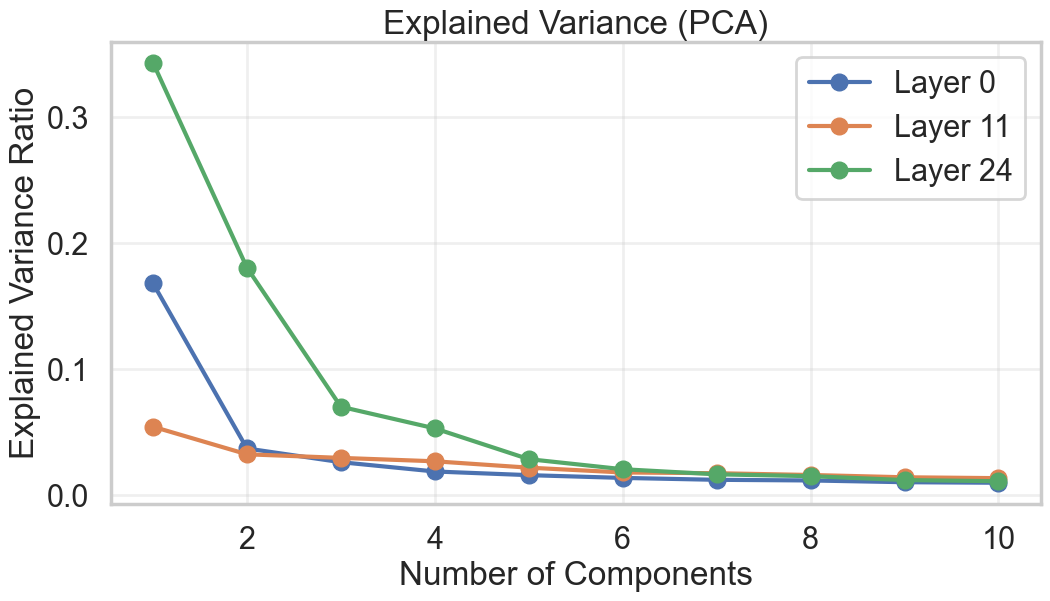

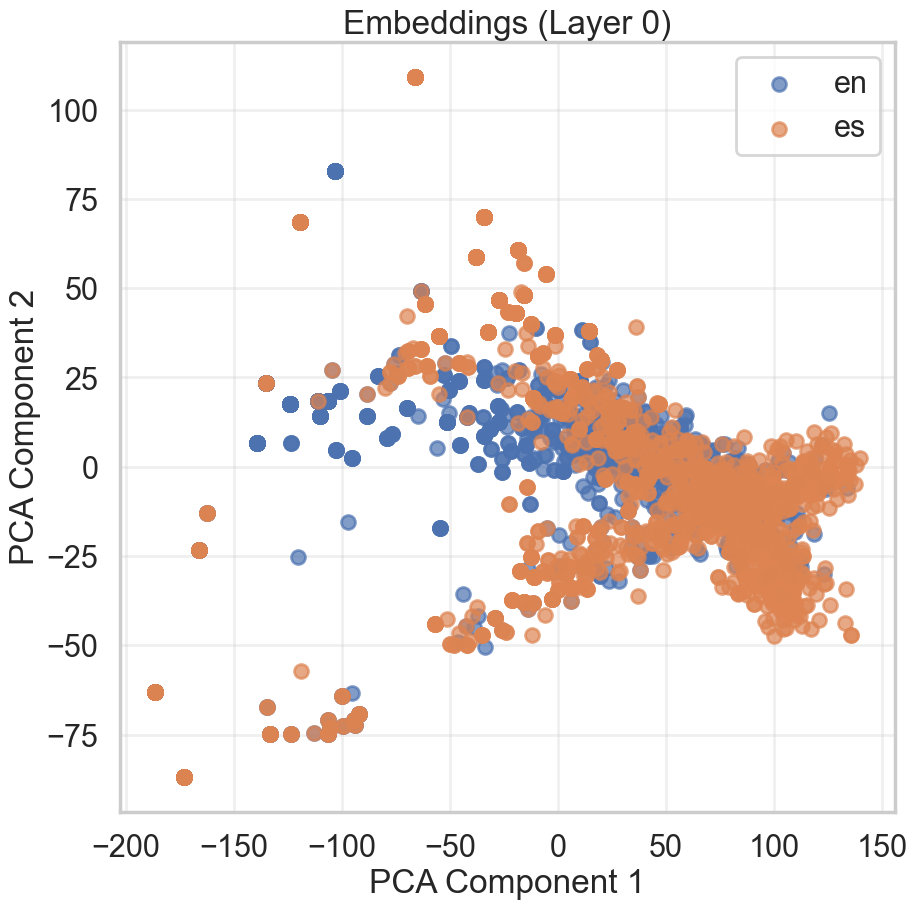

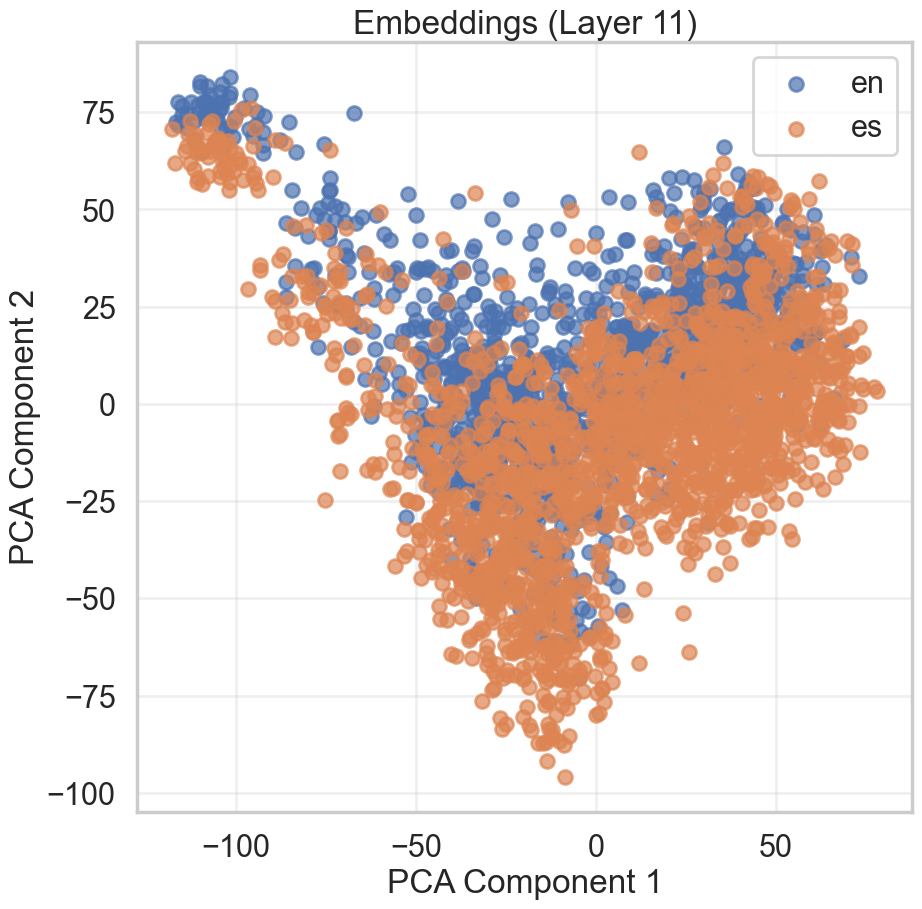

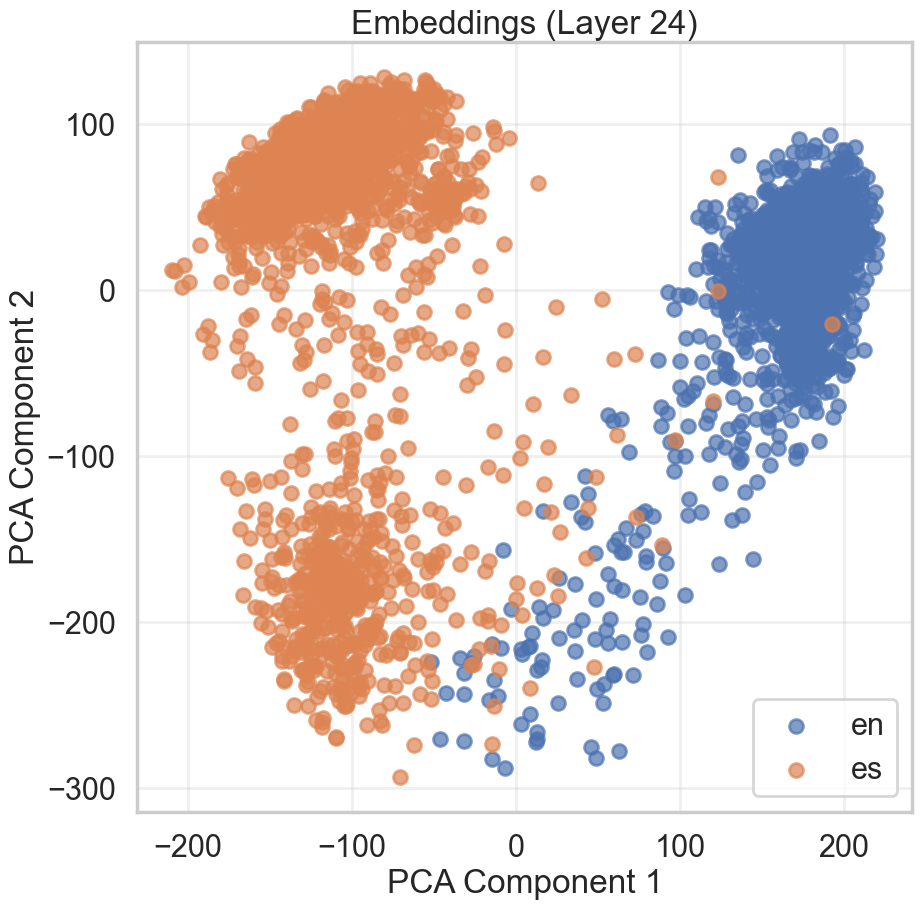

Data len:  100


100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


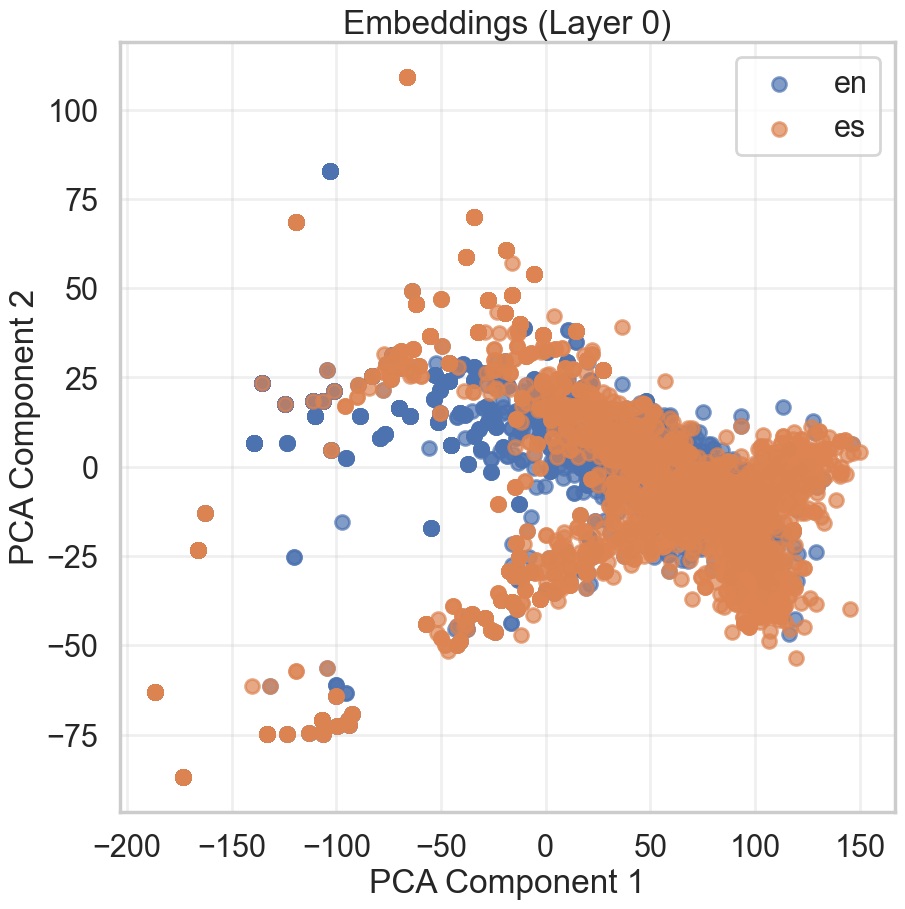

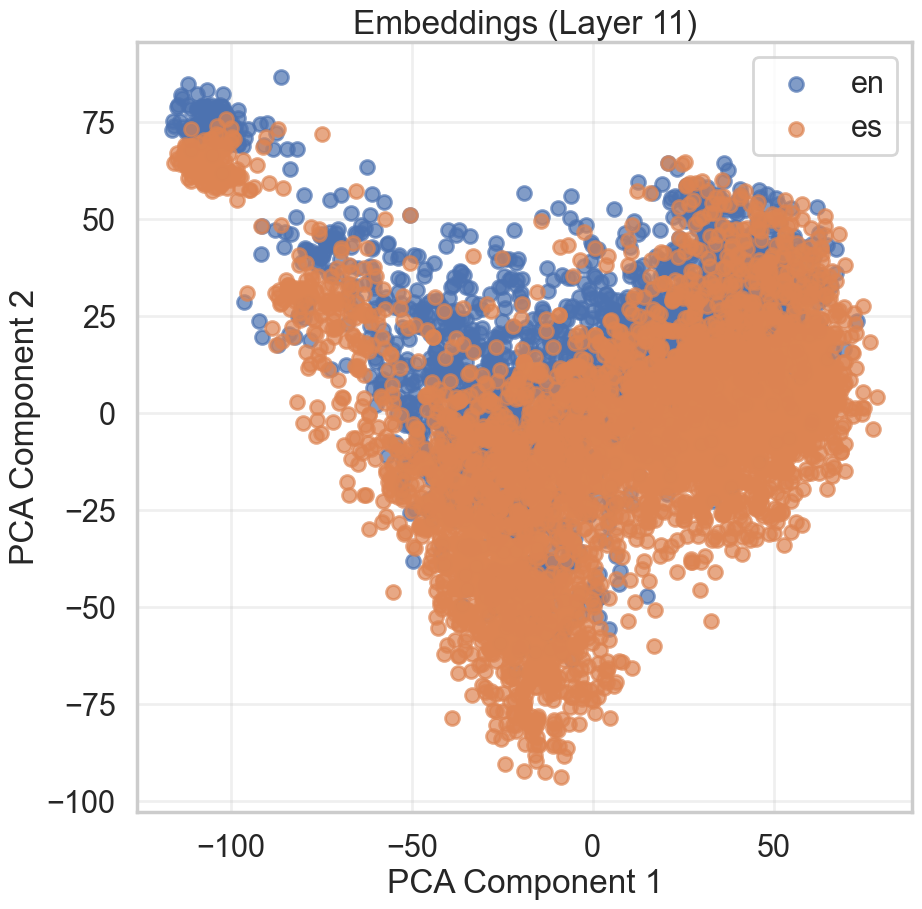

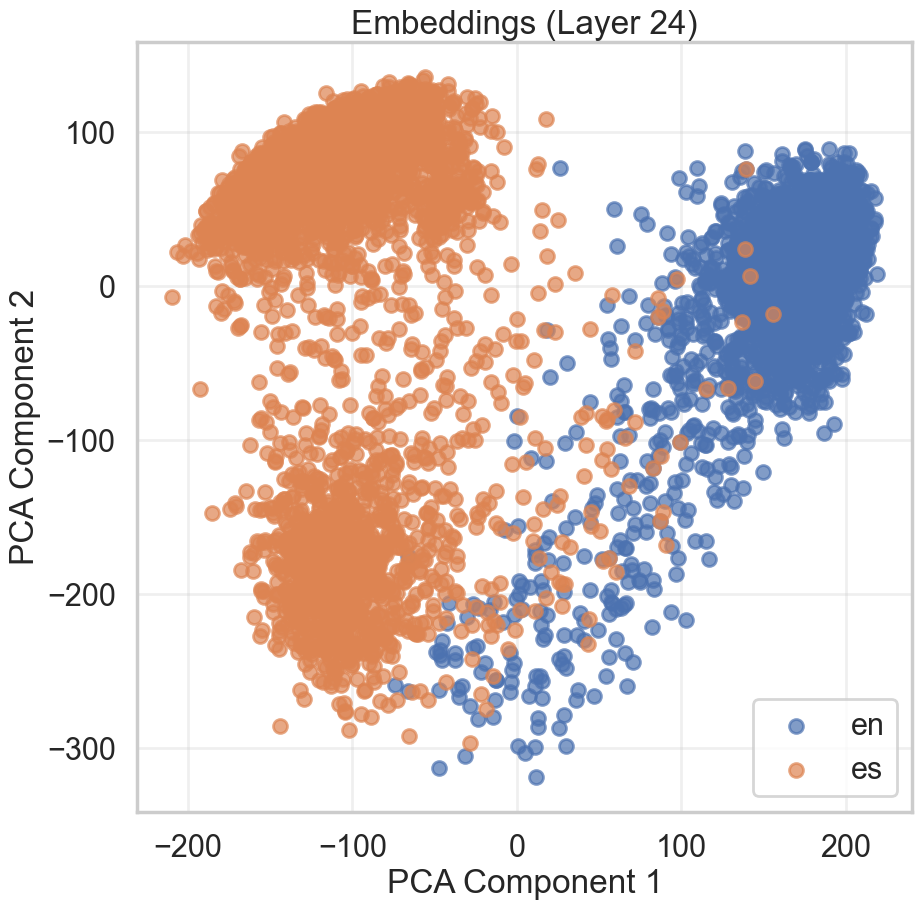

In [ ]:
from core.visualize.process_hidden_space import extract_pca_components, project_onto_pca

from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.preprocess_data.flores_plus import load_flores_plus
from core.visualize.visualize_projections import visualize_explained_variance, visualize_projections

train_df, test_df = load_flores_plus(["eng_Latn", "spa_Latn"], {"eng_Latn": "en", "spa_Latn": "es"}, train_size=50)

test_df = test_df[:100]

hidden_space_by_language_train = collect_hidden_space_by_language(model, tokenizer, train_df)
pca_components, pca_means, explained_variance_ratios = extract_pca_components(hidden_space_by_language_train)
visualize_explained_variance(pca_components, explained_variance_ratios)

projections_train = project_onto_pca(hidden_space_by_language_train, pca_components, pca_means)
visualize_projections(hidden_space_by_language_train, projections_train)

hidden_space_by_language_test = collect_hidden_space_by_language(model, tokenizer, test_df)
projections_test = project_onto_pca(hidden_space_by_language_test, pca_components, pca_means)
visualize_projections(hidden_space_by_language_test, projections_test)

# EN-Arab


Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Data len:  50


100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


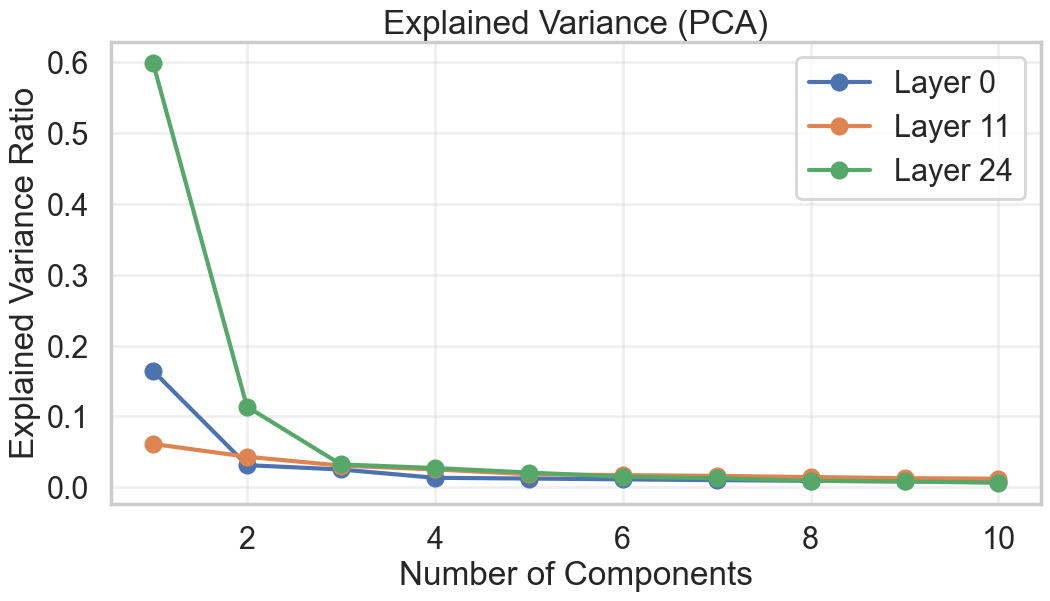

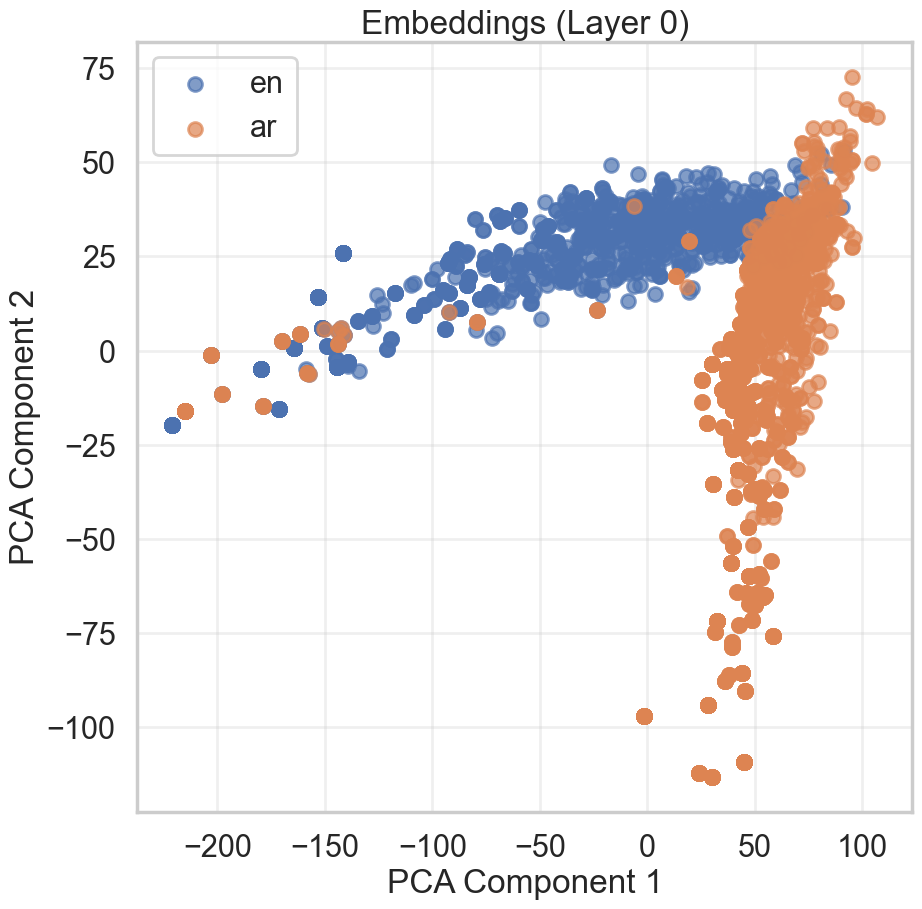

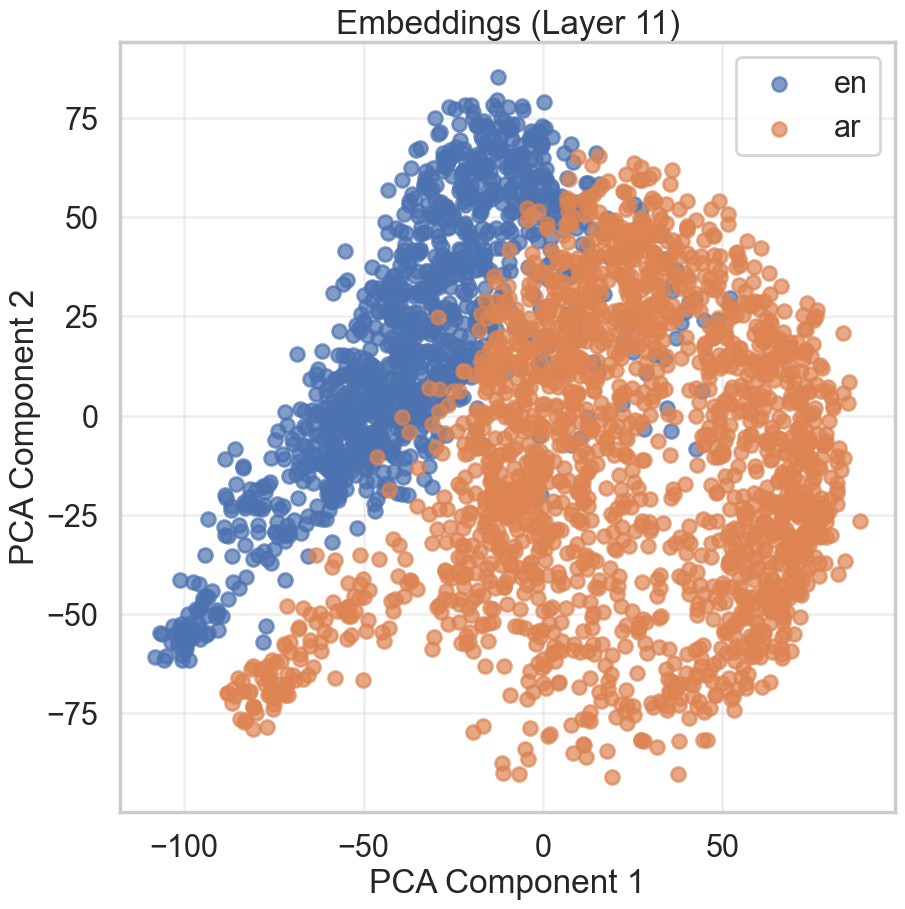

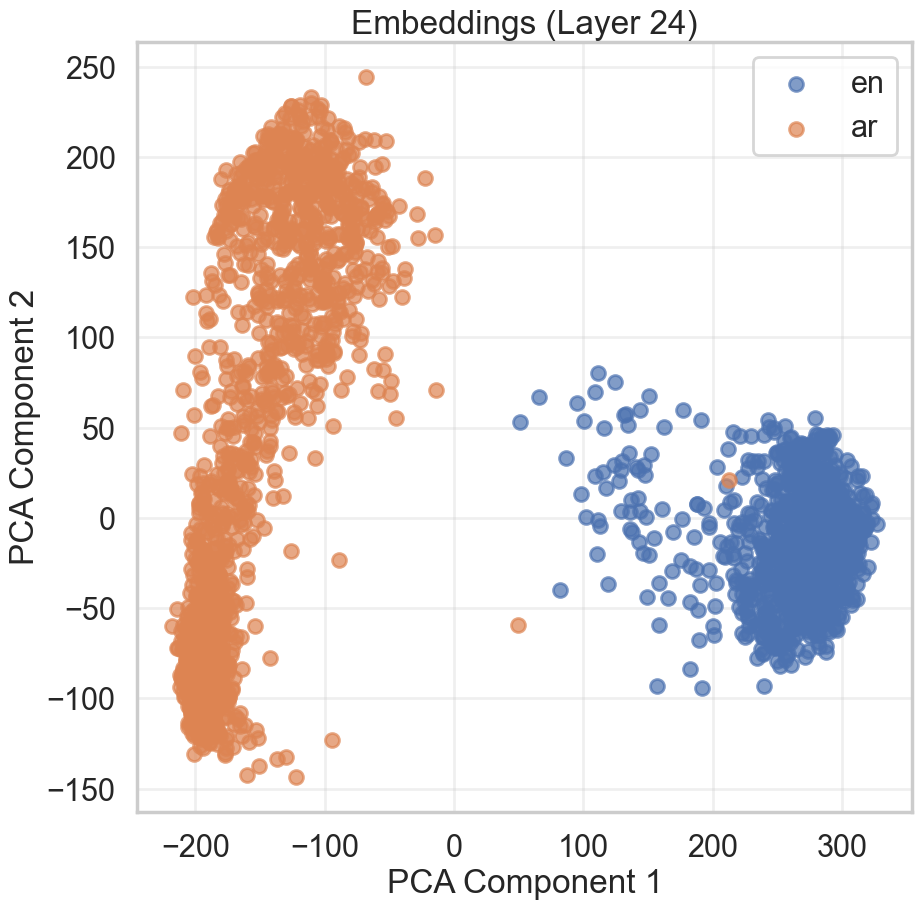

Data len:  100


100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


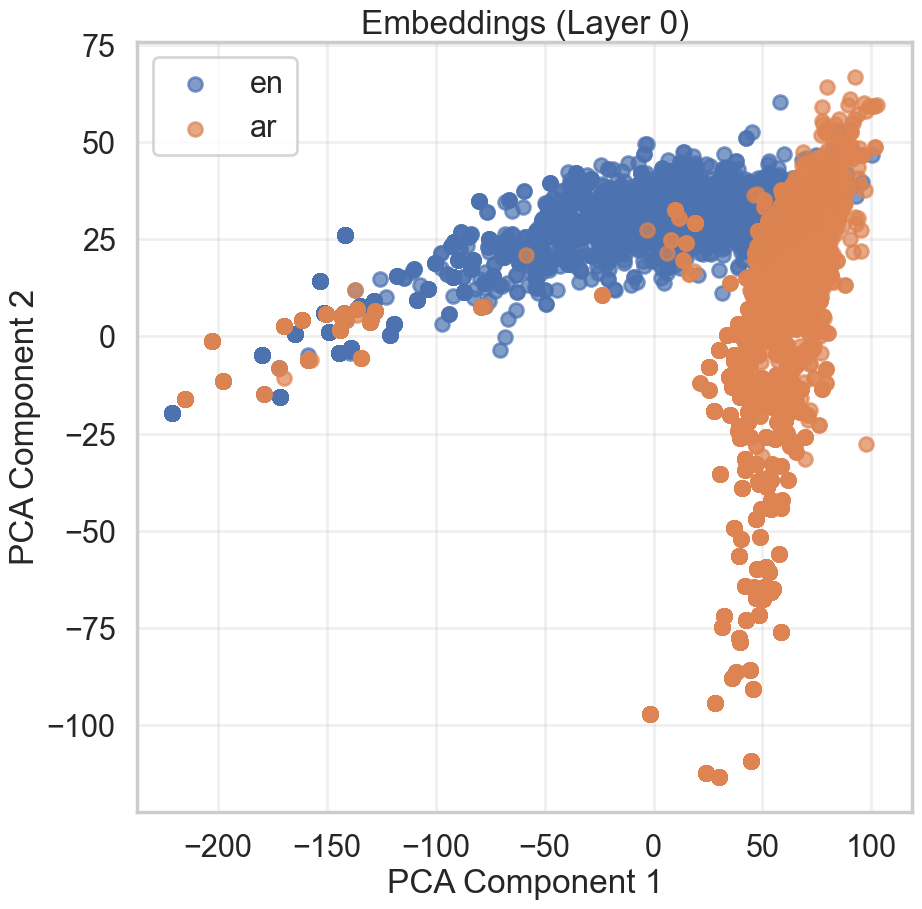

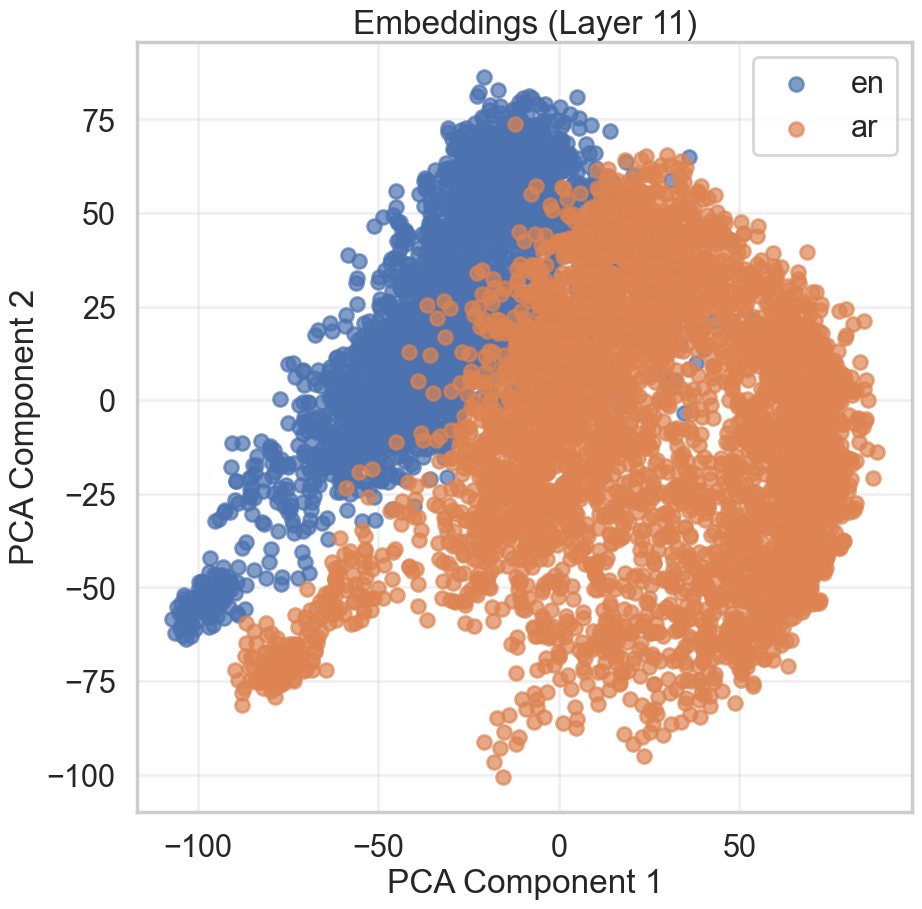

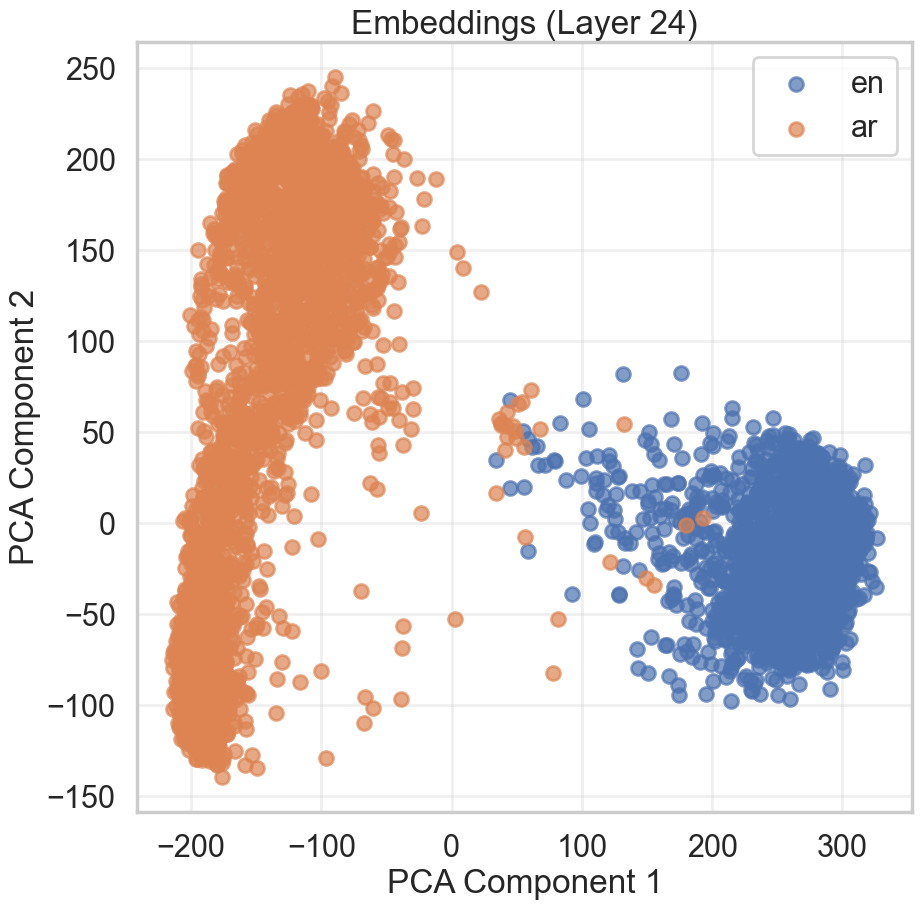

In [ ]:
from core.visualize.process_hidden_space import extract_pca_components, project_onto_pca

from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.preprocess_data.flores_plus import load_flores_plus
from core.visualize.visualize_projections import visualize_explained_variance, visualize_projections

train_df, test_df = load_flores_plus(["eng_Latn", "arb_Arab"], {"eng_Latn": "en", "arb_Arab": "ar"}, train_size=50)

test_df = test_df[:100]

hidden_space_by_language_train = collect_hidden_space_by_language(model, tokenizer, train_df)
pca_components, pca_means, explained_variance_ratios = extract_pca_components(hidden_space_by_language_train)
visualize_explained_variance(pca_components, explained_variance_ratios)

projections_train = project_onto_pca(hidden_space_by_language_train, pca_components, pca_means)
visualize_projections(hidden_space_by_language_train, projections_train)

hidden_space_by_language_test = collect_hidden_space_by_language(model, tokenizer, test_df)
projections_test = project_onto_pca(hidden_space_by_language_test, pca_components, pca_means)
visualize_projections(hidden_space_by_language_test, projections_test)

# Multi


Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Data len:  50


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]


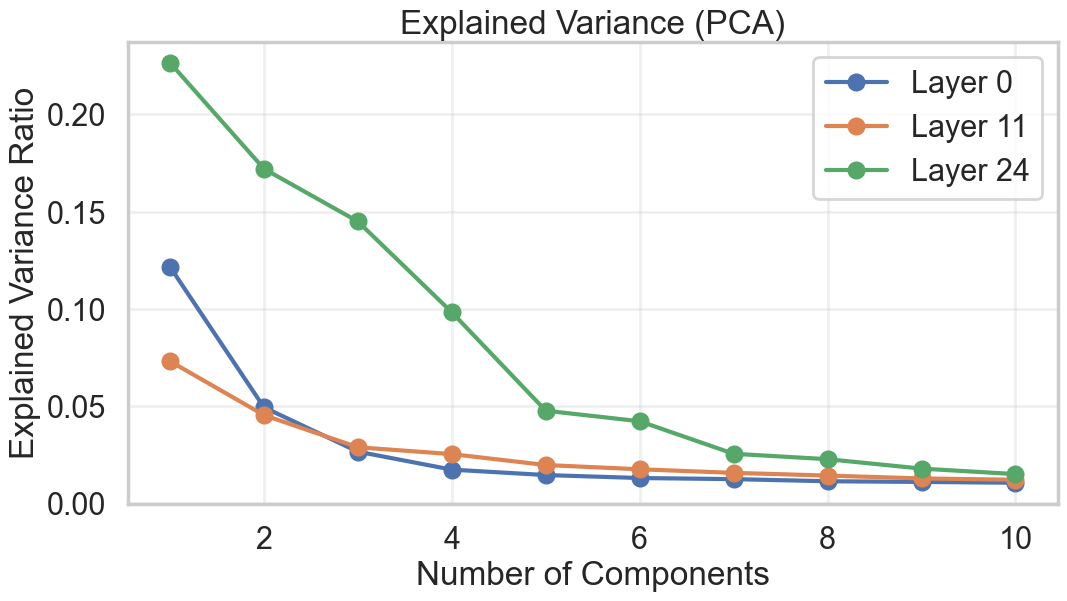

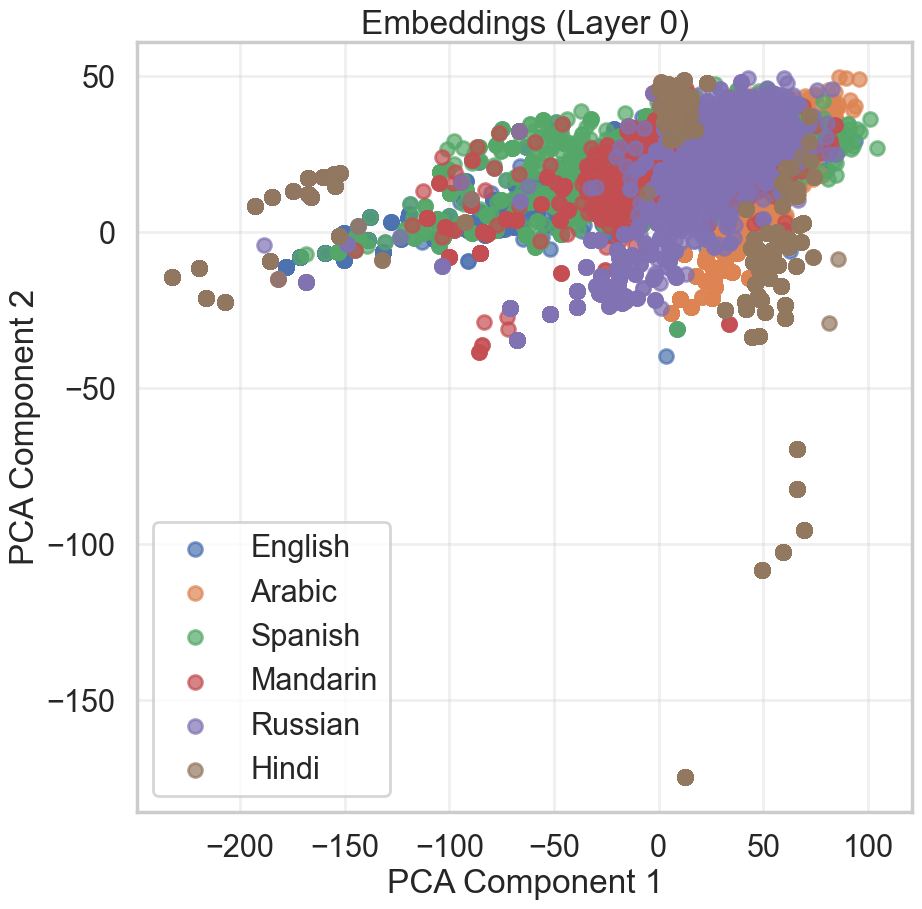

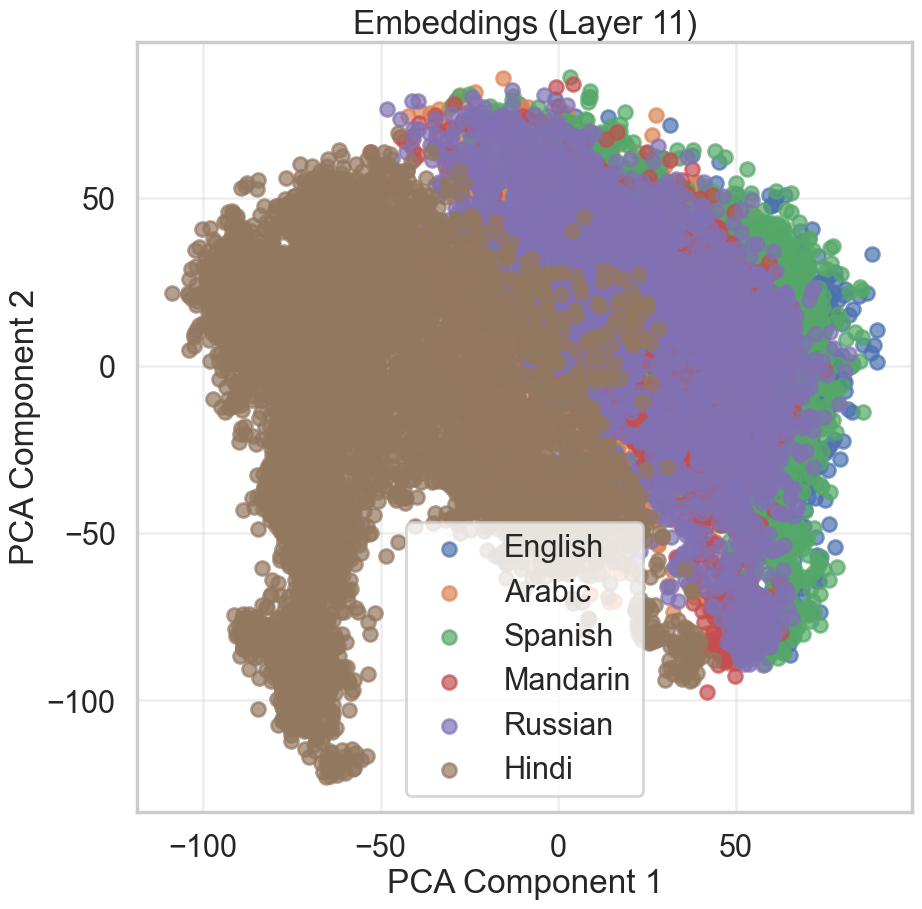

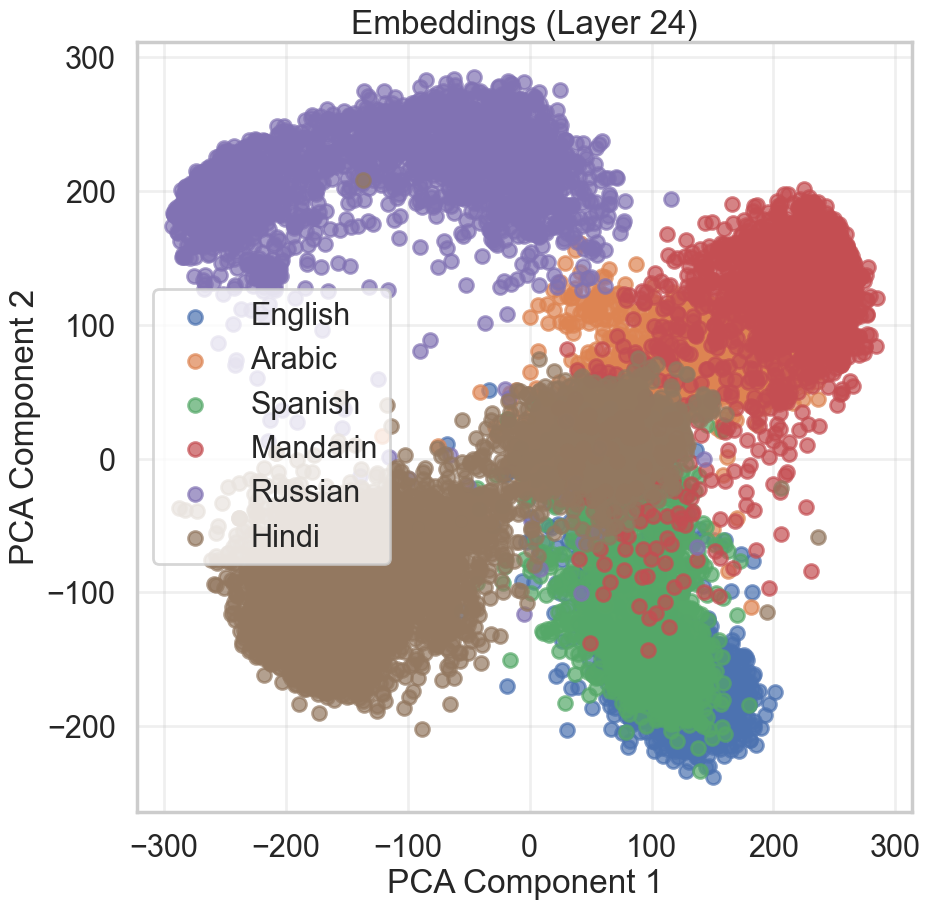

Data len:  100


100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


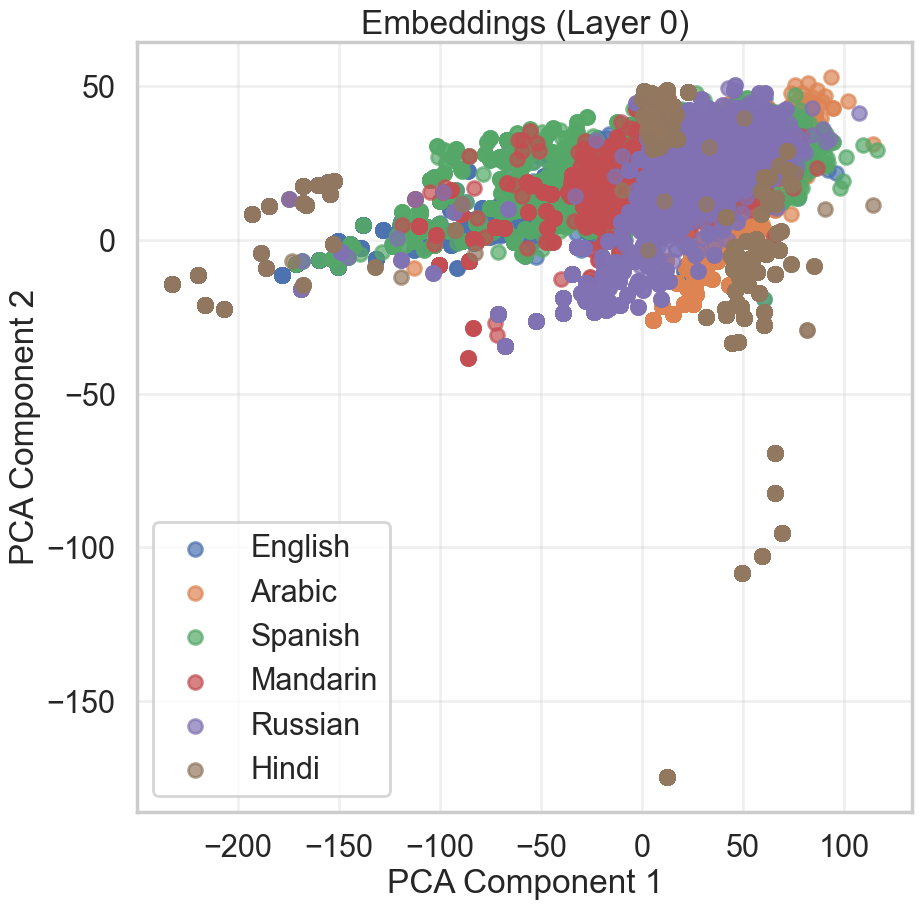

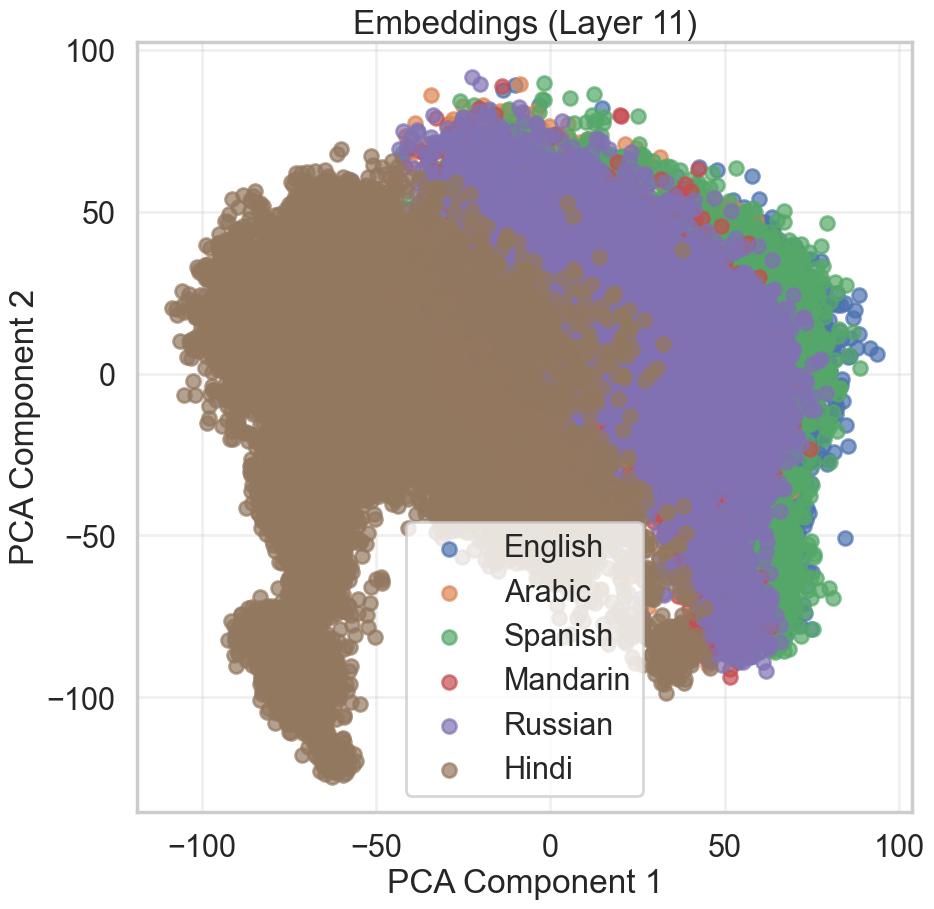

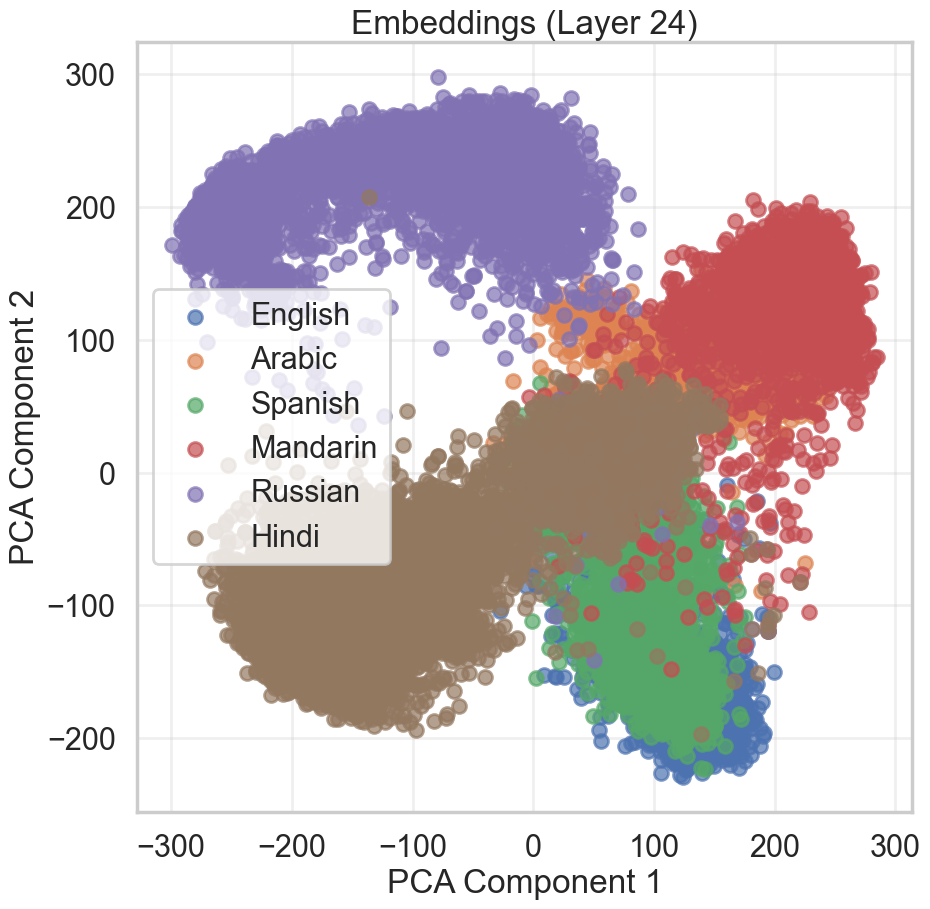

In [ ]:
from core.visualize.process_hidden_space import extract_pca_components, project_onto_pca

from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.preprocess_data.flores_plus import load_flores_plus
from core.visualize.visualize_projections import visualize_explained_variance, visualize_projections

train_df, test_df = load_flores_plus(
    ["eng_Latn", "arb_Arab", "spa_Latn", "cmn_Hans", "rus_Cyrl", "hin_Deva"],
    {
        "eng_Latn": "English",
        "arb_Arab": "Arabic",
        "spa_Latn": "Spanish",
        "cmn_Hans": "Mandarin",
        "rus_Cyrl": "Russian",
        "hin_Deva": "Hindi",
    },
    train_size=50,
)

test_df = test_df[:100]

hidden_space_by_language_train = collect_hidden_space_by_language(model, tokenizer, train_df)
pca_components, pca_means, explained_variance_ratios = extract_pca_components(hidden_space_by_language_train)
visualize_explained_variance(pca_components, explained_variance_ratios)

projections_train = project_onto_pca(hidden_space_by_language_train, pca_components, pca_means)
visualize_projections(hidden_space_by_language_train, projections_train)

hidden_space_by_language_test = collect_hidden_space_by_language(model, tokenizer, test_df)
projections_test = project_onto_pca(hidden_space_by_language_test, pca_components, pca_means)
visualize_projections(hidden_space_by_language_test, projections_test)